# Day 13: Mine Cart Madness

In [63]:
import numpy as np

TRACK  = 1
ANGLE1 = 2
ANGLE2 = 3
CROSS  = 4
CART   = 7

# directions as complex number
dirs = {}
dirs[">"] = +1
dirs["<"] = -1
dirs["^"] = -1j
dirs["v"] = +1j

tracks = [ "-", "|" ]
carts  = [ ">", "<", "^", "v"]

def getLines(filename):
    with open(filename) as f:
        lines = [ l.strip("\n") for l in f.readlines() ]
        return lines

def getGrid(lines):
    grid = np.zeros((len(lines),len(lines[0])),dtype=int)
    cart = []
    i = 1j # imaginary unit
    for y in range(len(lines)):
        for x in range(len(lines[0])):
            if lines[y][x] in tracks:
                grid[y][x] = TRACK
            elif lines[y][x] == "\\":
                grid[y][x] = ANGLE1
            elif lines[y][x] == "/":
                grid[y][x] = ANGLE2
            elif lines[y][x] == "+":
                grid[y][x] = CROSS
            elif lines[y][x] in carts:
                grid[y][x] = TRACK
                c = x+i*y
                # saving carts as (X+iY), direction, sense, last turn index
                cart.append((c,c,dirs[lines[y][x]],0))
    return grid,cart

import matplotlib.pyplot as plt

def drawGrid(cart,grid):
    print(cart)
    prev = []
    for c,cold,d,t in cart:
        x = int(c.real)
        y = int(c.imag)
        if x!=-999 and y!=-999:
            prev.append(grid[y][x])
            grid[y][x] = CART
        else:
            prev.append(None)
    plt.imshow(grid)
    plt.show()
    for C,p in zip(cart,prev):
        c,cold,d,t = C
        x = int(c.real)
        y = int(c.imag)
        if p!=None:
            grid[y][x] = p

[((2+0j), (2+0j), 1, 0), ((9+3j), (9+3j), 1j, 0)]


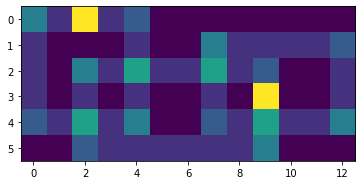

In [64]:
filename = "data/day13test1.txt"
grid,cart = getGrid(getLines(filename))
drawGrid(cart,grid)

In [120]:
from collections import Counter
from itertools import combinations

def race(cart,grid,removeCrash=False,verbose=False):

    if verbose:
        drawGrid(cart,grid)

    while True:

        # sort carts according to Y position
        #cart = sorted(cart,key=lambda x: int(x[0].imag))
        
        cart = sorted(cart,key=lambda x: (x[0].imag,x[0].real) )      
        if verbose:
            print("old positions:",cart)

        # move carts
        cartnew = []
        
        for i in range(len(cart)):

            C = cart[i] 
            c,cold,d,t = C   
            x = int(c.real)
            y = int(c.imag)
            
            if x==-999 and y==-999:
                continue

            if grid[y][x] == TRACK:
                cnew = c+d
                cold = c
                #cartnew.append( (cnew,cold,d,t) )
                cart[i] = (cnew,cold,d,t)

            elif grid[y][x] == ANGLE1: # \
                if c-cold == +1: # horiz left to righ, turn down
                    cnew = x + (y+1) * 1j
                    d = dirs["v"]
                elif c-cold == -1: # horiz right to left, turn up
                    cnew = x + (y-1) * 1j
                    d = dirs["^"]
                elif c-cold == -1j: # vert down to up, turn toward left
                    cnew = x-1 + y * 1j
                    d = dirs["<"]
                elif c-cold == +1j: # vert up to down, turn toward right
                    cnew = x+1 + y * 1j
                    d = dirs[">"]
                cold = c
                #cartnew.append( (cnew,cold,d,t) )
                cart[i] = (cnew,cold,d,t)
            
            elif grid[y][x] == ANGLE2: # /
                if c-cold == +1: # horiz left to righ, turn up
                    cnew = x + (y-1) * 1j
                    d = dirs["^"]
                elif c-cold == -1: # horiz right to left, turn down
                    cnew = x + (y+1) * 1j
                    d = dirs["v"]
                elif c-cold == -1j: # vert down to up, turn toward right
                    cnew = x+1 + y * 1j
                    d = dirs[">"]
                elif c-cold == +1j: # vert up to down, turn toward left
                    cnew = x-1 + y * 1j
                    d = dirs["<"]
                cold = c
                #cartnew.append( (cnew,cold,d,t) )
                cart[i] = (cnew,cold,d,t)
            
            elif grid[y][x] == CROSS:
                if t==0: # turn left
                    cnew = c-d*1j
                    dnew = d*-1j
                elif t==1: # go straight
                    cnew = c+d
                    dnew = d
                elif t==2: # turn right
                    cnew = c+d*1j
                    dnew = d*1j
                tnew = (t+1)%3
                cold = c
                #cartnew.append( (cnew,cold,dnew,tnew) )
                cart[i] = (cnew,cold,dnew,tnew)
                
            # check for collisions after having moved each cart
            for C2 in cart:
                if C2!=C:
                    c2,_,_,_ = C2
                    if c==c2:
                        cart[i] = ((-999-999j),(-999-999j),dirs["^"],0)
                        cart[cart.index(C2)] = ((-999-999j),(-999-999j),dirs["^"],0)
                        if not removeCrash: # stop iteration ar first crach to solve Part 1
                            print("Collision at (X,Y) = ({},{})".format(int(c.real),int(c.imag)))
                            return

            if removeCrash: # count remaining acrive carts to solve Part 2
                active = 0
                xs = 0
                ys = 0
                for j in range(len(cart)):
                    Cj = cart[j] 
                    cj,_,_,_ = Cj   
                    xj = int(cj.real)
                    yj = int(cj.imag)   
                    if xj!=-999 and yj!=-999:
                        active +=1
                        xs = xj
                        ys = yj
                if verbose:
                    print("Active carts =",active)
                    drawGrid(cart,grid)
                if active==1:
                    print("Surviving cart at (X,Y) = ({},{})".format(xs,ys))
                    return

        if verbose:
            print("new positions:",cart)    
            drawGrid(cart,grid)
            
        if len(cart)==1:
            c,cold,d,t = cart[0]
            print("Survivor cart at (X,Y) = ({},{})".format(int(c.real),int(c.imag)))
            return

[((2+0j), (2+0j), 1, 0), ((9+3j), (9+3j), 1j, 0)]


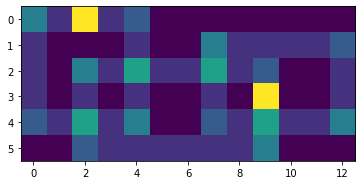

old positions: [((2+0j), (2+0j), 1, 0), ((9+3j), (9+3j), 1j, 0)]
new positions: [((3+0j), (2+0j), 1, 0), ((9+4j), (9+3j), 1j, 0)]
[((3+0j), (2+0j), 1, 0), ((9+4j), (9+3j), 1j, 0)]


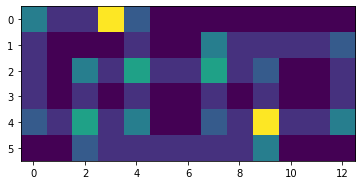

old positions: [((3+0j), (2+0j), 1, 0), ((9+4j), (9+3j), 1j, 0)]
new positions: [((4+0j), (3+0j), 1, 0), ((10+4j), (9+4j), (1-0j), 1)]
[((4+0j), (3+0j), 1, 0), ((10+4j), (9+4j), (1-0j), 1)]


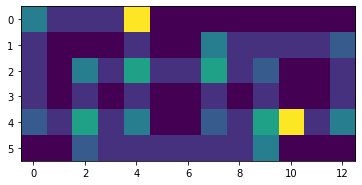

old positions: [((4+0j), (3+0j), 1, 0), ((10+4j), (9+4j), (1-0j), 1)]
new positions: [((4+1j), (4+0j), 1j, 0), ((11+4j), (10+4j), (1-0j), 1)]
[((4+1j), (4+0j), 1j, 0), ((11+4j), (10+4j), (1-0j), 1)]


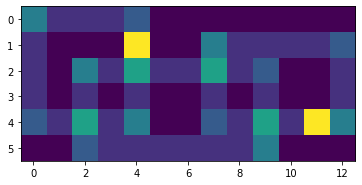

old positions: [((4+1j), (4+0j), 1j, 0), ((11+4j), (10+4j), (1-0j), 1)]
new positions: [((4+2j), (4+1j), 1j, 0), ((12+4j), (11+4j), (1-0j), 1)]
[((4+2j), (4+1j), 1j, 0), ((12+4j), (11+4j), (1-0j), 1)]


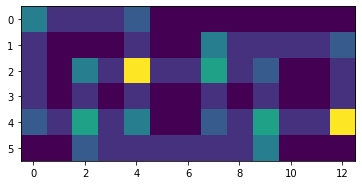

old positions: [((4+2j), (4+1j), 1j, 0), ((12+4j), (11+4j), (1-0j), 1)]
new positions: [((5+2j), (4+2j), (1-0j), 1), ((12+3j), (12+4j), (-0-1j), 1)]
[((5+2j), (4+2j), (1-0j), 1), ((12+3j), (12+4j), (-0-1j), 1)]


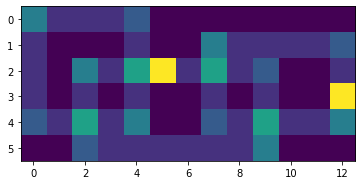

old positions: [((5+2j), (4+2j), (1-0j), 1), ((12+3j), (12+4j), (-0-1j), 1)]
new positions: [((6+2j), (5+2j), (1-0j), 1), ((12+2j), (12+3j), (-0-1j), 1)]
[((6+2j), (5+2j), (1-0j), 1), ((12+2j), (12+3j), (-0-1j), 1)]


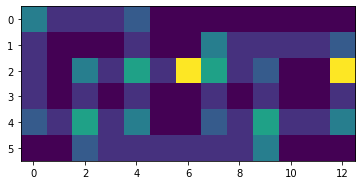

old positions: [((6+2j), (5+2j), (1-0j), 1), ((12+2j), (12+3j), (-0-1j), 1)]
new positions: [((7+2j), (6+2j), (1-0j), 1), ((12+1j), (12+2j), (-0-1j), 1)]
[((7+2j), (6+2j), (1-0j), 1), ((12+1j), (12+2j), (-0-1j), 1)]


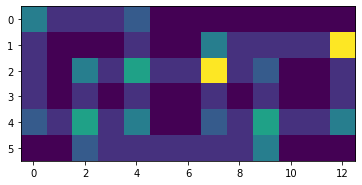

old positions: [((12+1j), (12+2j), (-0-1j), 1), ((7+2j), (6+2j), (1-0j), 1)]
new positions: [((11+1j), (12+1j), -1, 1), ((8+2j), (7+2j), (1-0j), 2)]
[((11+1j), (12+1j), -1, 1), ((8+2j), (7+2j), (1-0j), 2)]


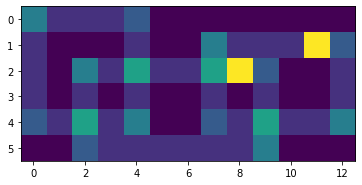

old positions: [((11+1j), (12+1j), -1, 1), ((8+2j), (7+2j), (1-0j), 2)]
new positions: [((10+1j), (11+1j), -1, 1), ((9+2j), (8+2j), (1-0j), 2)]
[((10+1j), (11+1j), -1, 1), ((9+2j), (8+2j), (1-0j), 2)]


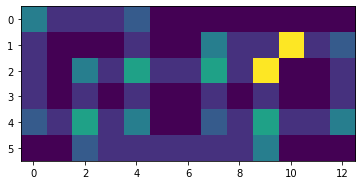

old positions: [((10+1j), (11+1j), -1, 1), ((9+2j), (8+2j), (1-0j), 2)]
new positions: [((9+1j), (10+1j), -1, 1), ((9+3j), (9+2j), 1j, 2)]
[((9+1j), (10+1j), -1, 1), ((9+3j), (9+2j), 1j, 2)]


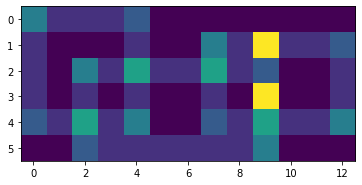

old positions: [((9+1j), (10+1j), -1, 1), ((9+3j), (9+2j), 1j, 2)]
new positions: [((8+1j), (9+1j), -1, 1), ((9+4j), (9+3j), 1j, 2)]
[((8+1j), (9+1j), -1, 1), ((9+4j), (9+3j), 1j, 2)]


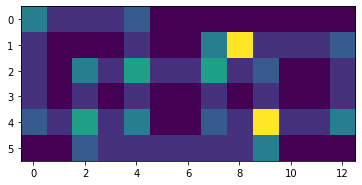

old positions: [((8+1j), (9+1j), -1, 1), ((9+4j), (9+3j), 1j, 2)]
new positions: [((7+1j), (8+1j), -1, 1), ((8+4j), (9+4j), (-1+0j), 0)]
[((7+1j), (8+1j), -1, 1), ((8+4j), (9+4j), (-1+0j), 0)]


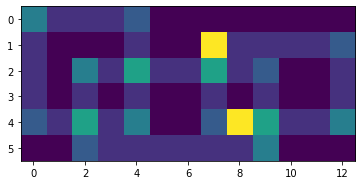

old positions: [((7+1j), (8+1j), -1, 1), ((8+4j), (9+4j), (-1+0j), 0)]
new positions: [((7+2j), (7+1j), 1j, 1), ((7+4j), (8+4j), (-1+0j), 0)]
[((7+2j), (7+1j), 1j, 1), ((7+4j), (8+4j), (-1+0j), 0)]


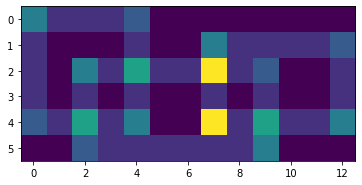

old positions: [((7+2j), (7+1j), 1j, 1), ((7+4j), (8+4j), (-1+0j), 0)]
new positions: [((7+3j), (7+2j), 1j, 2), ((7+3j), (7+4j), (-0-1j), 0)]
[((7+3j), (7+2j), 1j, 2), ((7+3j), (7+4j), (-0-1j), 0)]


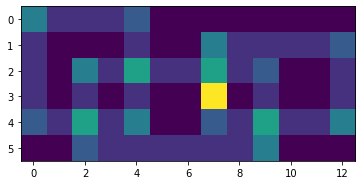

old positions: [((7+3j), (7+2j), 1j, 2), ((7+3j), (7+4j), (-0-1j), 0)]
Collision at (X,Y) = (7,3)


In [121]:
filename = "data/day13test1.txt"
grid,cart = getGrid(getLines(filename))
race(cart,grid,verbose=True)

In [122]:
filename = "data/input13.txt"
grid,cart = getGrid(getLines(filename))
race(cart,grid,verbose=False)

Collision at (X,Y) = (38,57)


In [123]:
filename = "data/day13test2.txt"
grid,cart = getGrid(getLines(filename))
race(cart,grid,removeCrash=True,verbose=False)

Surviving cart at (X,Y) = (6,4)


In [124]:
filename = "data/input13.txt"

grid,cart = getGrid(getLines(filename))

race(cart,grid,removeCrash=True,verbose=False)

Surviving cart at (X,Y) = (4,92)
